# Flood Prediction — Report Artifacts (v6+)
*Generated 2025-08-12 13:54*

This notebook builds the **report-ready analyses** you asked for:
- Error analysis (top FP/FN) per station with last 12h rain/flow features
- Feature impact: LightGBM importances (top 15) + short auto-notes
- Ablation matrix: XGB only → +Stack → +LGBM → +LSTM (PR-AUC, Recall@thr, FP, FN)
- Per-station PR curves with threshold marker
- Confusion matrices (per station + combined)
- Timeline panels of the last 2–3 notable flood events with rain vs discharge vs predicted probability

> It retrains per-station models using **70/30 stratified** split and your fixed thresholds:
> - D08A071 → 0.50
> - D08A084 → 0.533
> - D08A115 → 0.932


In [1]:

import os, random, joblib, warnings
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, confusion_matrix,
    precision_score, recall_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

# Optional learners
try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from scikeras.wrappers import KerasClassifier
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
    from tensorflow.keras.optimizers import Adam
    import tensorflow as tf
    HAS_LSTM = True
except Exception:
    HAS_LSTM = False

print("HAS_LGBM:", HAS_LGBM, "HAS_XGB:", HAS_XGB, "HAS_LSTM:", HAS_LSTM)


HAS_LGBM: True HAS_XGB: True HAS_LSTM: True


In [2]:

SEED = 42
np.random.seed(SEED); random.seed(SEED)
try:
    import tensorflow as _tf_seed
    _tf_seed.random.set_seed(SEED)
except Exception:
    pass

DATA_RAW = Path('/Users/tree/Projects/hydro-flood-poc/data/raw')
STATIONS = ['D08A071','D08A084','D08A115']
MY_THR: Dict[str, float] = {'D08A071': 0.50, 'D08A084': 0.533, 'D08A115': 0.932}

# Labeling & FE
PERCENTILE = 0.82
LEAD_HRS   = 2

ROLL_RAIN  = [1,3,6,12,24]
LAG_Q      = list(range(1,13))
ROLL_Q_MAX = [3,6,12]
ROLL_Q_MIN = [3,6,12]
ROLL_Q_STD = [3,6,12]
EWMA_RAIN_HALFLIFE = 12

OUTDIR = Path("report_artifacts")
OUTDIR.mkdir(exist_ok=True)


In [3]:

def find_csv_for_station(root: Path, code: str) -> Path:
    folder = root / f'station_{code}'
    cands = sorted(folder.glob('*.csv'))
    if not cands:
        raise FileNotFoundError(f'No CSV in {folder}')
    return cands[0]

def load_station(code: str) -> pd.DataFrame:
    csv = find_csv_for_station(DATA_RAW, code)
    df = pd.read_csv(csv)
    df['datetime'] = pd.to_datetime(df['saatlik'])
    df = (df.rename(columns={'yagis_toplam':'rain_mm','qdeger':'discharge_cms'})
            .set_index('datetime').sort_index())
    df = df.resample('h').agg({'rain_mm':'sum','discharge_cms':'mean'})
    return df[~df.index.duplicated(keep='first')]

def add_seasonal_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour.values; doy = idx.dayofyear.values
    feat = pd.DataFrame(index=idx)
    feat['hour_sin'] = np.sin(2*np.pi*hour/24)
    feat['hour_cos'] = np.cos(2*np.pi*hour/24)
    feat['doy_sin']  = np.sin(2*np.pi*doy/366)
    feat['doy_cos']  = np.cos(2*np.pi*doy/366)
    return feat

def build_features(base: pd.DataFrame):
    df = base.copy()
    # Rain
    for w in ROLL_RAIN:
        df[f'rain_sum_{w}h'] = df['rain_mm'].rolling(w, min_periods=1).sum()
    df['rain_ewm'] = df['rain_mm'].ewm(halflife=EWMA_RAIN_HALFLIFE, adjust=False).mean()
    # Discharge
    for l in LAG_Q: df[f'dis_lag_{l}h'] = df['discharge_cms'].shift(l)
    df['dis_rate_1h'] = df['discharge_cms'].diff(1)
    df['dis_rate_3h'] = df['discharge_cms'].diff(3)
    for w in ROLL_Q_MAX: df[f'dis_max_{w}h'] = df['discharge_cms'].rolling(w, min_periods=1).max()
    for w in ROLL_Q_MIN: df[f'dis_min_{w}h'] = df['discharge_cms'].rolling(w, min_periods=1).min()
    for w in ROLL_Q_STD: df[f'dis_std_{w}h'] = df['discharge_cms'].rolling(w, min_periods=3).std()
    # Dry spell
    rb = (df['rain_mm']>0).astype(int); gaps=[]; c=0
    for v in rb: c=0 if v==1 else c+1; gaps.append(c)
    df['hrs_since_rain'] = gaps
    # Interactions
    df['rain3xlag1'] = df.get('rain_sum_3h',0)*df.get('dis_lag_1h',0)
    df['rain6xlag3'] = df.get('rain_sum_6h',0)*df.get('dis_lag_3h',0)
    # Seasonality
    df = df.join(add_seasonal_features(df.index))
    # Label for t+LEAD_HRS
    thr = df['discharge_cms'].quantile(PERCENTILE)
    y = (df['discharge_cms'] > thr).astype(int).shift(-LEAD_HRS)
    df['flood'] = y
    df = df.dropna()
    X = df.drop(columns=['flood'])
    y = df['flood']
    return X, y, df  # df includes discharge_cms, rain_mm aligned with X


In [4]:

def make_lstm_estimator(n_features: int):
    if not HAS_LSTM:
        return None
    def to_seq(X):
        X = np.asarray(X, dtype=np.float32)
        return X.reshape((X.shape[0], X.shape[1], 1))
    def build_model(n_features, units=16, lr=1e-3, drop=0.2):
        try:
            import tensorflow as tf
            tf.random.set_seed(SEED)
        except Exception:
            pass
        m = Sequential([
            Input(shape=(n_features,1)),
            LSTM(units),
            Dropout(drop),
            Dense(1, activation='sigmoid')
        ])
        m.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy')
        return m
    est = Pipeline([
        ('sc', StandardScaler()),
        ('seq', FunctionTransformer(to_seq, validate=False)),
        ('lstm', KerasClassifier(
            model=build_model,
            model__n_features=n_features, model__units=16, model__lr=1e-3, model__drop=0.2,
            epochs=30, batch_size=256, verbose=0, random_state=SEED
        ))
    ])
    return est

def make_base_models(n_pos: int, n_neg: int, n_features: int):
    spw = (n_neg / max(1, n_pos)) if n_pos>0 else 1.0
    models = []
    if HAS_XGB:
        models.append(('xgb', XGBClassifier(
            n_estimators=500, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            random_state=SEED, tree_method='hist', eval_metric='logloss',
            scale_pos_weight=spw
        )))
    models += [
        ('rf',  RandomForestClassifier(n_estimators=400, min_samples_leaf=2, class_weight='balanced', random_state=SEED, n_jobs=-1)),
        ('gb',  GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=3, random_state=SEED)),
        ('lr',  LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs', random_state=SEED)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(64,32), activation='relu', alpha=1e-3, max_iter=600, random_state=SEED)),
    ]
    if HAS_LGBM:
        models.append(('lgbm', lgb.LGBMClassifier(
            n_estimators=600, learning_rate=0.05, max_depth=-1,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            class_weight='balanced', random_state=SEED, n_jobs=-1, verbosity=-1
        )))
    lstm_est = make_lstm_estimator(n_features)
    if lstm_est is not None:
        models.append(('lstm', lstm_est))
    return models

def make_stacker(base_models):
    meta = LogisticRegression(max_iter=3000, class_weight='balanced', solver='lbfgs', random_state=SEED)
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    has_lstm = any(name=='lstm' for name,_ in base_models)
    return StackingClassifier(
        estimators=base_models,
        final_estimator=meta,
        stack_method='predict_proba',
        passthrough=True,
        cv=cv,
        n_jobs=(1 if has_lstm else -1)
    )

def evaluate_at_threshold(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = precision_score(y_true, y_hat, zero_division=0)
    rec  = recall_score(y_true, y_hat)
    ap   = average_precision_score(y_true, y_prob)
    return dict(threshold=float(thr), acc=acc, precision=prec, recall=rec, ap=ap,
                tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp))

def train_stack_and_probs(code):
    base = load_station(code)
    X, y, df_full = build_features(base)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=SEED, stratify=y)
    pre  = ColumnTransformer([('sc', StandardScaler(), X.columns.tolist())], remainder='drop')
    bm   = make_base_models(int(y_tr.sum()), int((y_tr==0).sum()), n_features=X.shape[1])
    stk  = make_stacker(bm)
    pipe = Pipeline([('pre', pre), ('model', stk)])
    pipe.fit(X_tr, y_tr)
    prob = pipe.predict_proba(X_te)[:,1]
    return X_tr, X_te, y_tr, y_te, prob, pipe, df_full


In [5]:

def error_analysis_tables(code, X_te, y_te, prob, df_full, thr, topn=20):
    # start from test feature frame
    te = X_te.copy()
    te['y_true'] = y_te.values
    te['proba']  = np.asarray(prob, dtype=float)
    te['pred']   = (te['proba'] >= thr).astype(int)

    # If raw columns are missing in X_te, pull them from df_full (and suffix to avoid clashes)
    for raw_col in ['discharge_cms', 'rain_mm']:
        if raw_col not in te.columns and raw_col in df_full.columns:
            te[f'{raw_col}_raw'] = df_full.loc[te.index, raw_col]

    # Build the columns we want to show (only those that exist)
    want = [
        'proba', 'y_true', 'pred',
        # prefer in-frame names; fall back to *_raw if present
        'discharge_cms' if 'discharge_cms' in te.columns else ('discharge_cms_raw' if 'discharge_cms_raw' in te.columns else None),
        'rain_mm'       if 'rain_mm'       in te.columns else ('rain_mm_raw'       if 'rain_mm_raw'       in te.columns else None),
        'rain_sum_12h', 'dis_lag_1h', 'dis_rate_1h',
    ]
    cols = [c for c in want if c is not None and c in te.columns]

    # Slice FP/FN
    fp = te[(te['pred']==1) & (te['y_true']==0)].sort_values('proba', ascending=False).head(topn)[cols]
    fn = te[(te['pred']==0) & (te['y_true']==1)].sort_values('proba', ascending=True ).head(topn)[cols]

    # Save & show
    fp_csv = OUTDIR / f"{code}_topFP.csv"
    fn_csv = OUTDIR / f"{code}_topFN.csv"
    fp.to_csv(fp_csv, index=True)
    fn.to_csv(fn_csv, index=True)
    print(f"Saved {fp_csv} and {fn_csv}")
    display(fp.head(10)); display(fn.head(10))

def plot_pr_with_marker(code, y_te, prob, thr):
    P,R,T = precision_recall_curve(y_te, prob)
    rec_at_thr = recall_score(y_te, (prob>=thr).astype(int))
    prec_at_thr = precision_score(y_te, (prob>=thr).astype(int), zero_division=0)
    plt.figure()
    plt.plot(R, P, label=f"AP={average_precision_score(y_te, prob):.3f}")
    plt.scatter([rec_at_thr],[prec_at_thr], marker='x', s=60, label=f"thr={thr:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve — {code}")
    plt.legend(); plt.tight_layout()
    outp = OUTDIR/f"pr_{code}.png"; plt.savefig(outp, dpi=150); plt.show()
    print("Saved", outp)

def plot_confusion(code, y_te, prob, thr):
    cm = confusion_matrix(y_te, (prob>=thr).astype(int), labels=[0,1])
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest')
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Pred 0','Pred 1']); ax.set_yticklabels(['True 0','True 1'])
    ax.set_title(f"Confusion Matrix — {code}"); plt.tight_layout()
    outp = OUTDIR/f"cm_{code}.png"; plt.savefig(outp, dpi=150); plt.show()
    print("Saved", outp)
    return cm


In [6]:

def lgbm_importance_and_notes(code, X_tr, y_tr):
    if not HAS_LGBM:
        print("LightGBM not installed; skipping.")
        return None
    clf = lgb.LGBMClassifier(
        n_estimators=800, learning_rate=0.03, num_leaves=63,
        subsample=0.9, colsample_bytree=0.9, class_weight='balanced',
        random_state=SEED, n_jobs=-1, verbosity=-1
    )
    clf.fit(X_tr, y_tr)
    imp = pd.Series(clf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
    top15 = imp.head(15)[::-1]
    plt.figure(figsize=(8,5))
    top15.plot(kind='barh')
    plt.title(f"LightGBM Importance — {code} (top 15)")
    plt.tight_layout()
    outp = OUTDIR/f"lgbm_importance_{code}.png"; plt.savefig(outp, dpi=150); plt.show()
    print("Saved", outp)
    # notes
    rain_feats = [f for f in imp.index if 'rain_' in f]
    lag_feats  = [f for f in imp.index if 'dis_lag_' in f]
    rate_feats = [f for f in imp.index if 'dis_rate_' in f]
    maxmin     = [f for f in imp.index if ('dis_max_' in f or 'dis_min_' in f or 'dis_std_' in f)]
    season     = [f for f in imp.index if ('hour_' in f or 'doy_' in f)]
    notes = []
    notes.append(f"1) Recent discharge lags dominate (e.g., {', '.join(lag_feats[:3])}).")
    notes.append(f"2) Short-horizon rainfall sums contribute ({', '.join([f for f in rain_feats if 'sum_3h' in f or 'sum_6h' in f][:2])}); EWMA captures persistence.")
    notes.append(f"3) Rate-of-change features ({', '.join(rate_feats[:2])}) help detect surges.")
    notes.append(f"4) Range/variability ({', '.join(maxmin[:2])}) adds volatility context.")
    notes.append(f"5) Mild seasonal effects present ({', '.join(season[:2])}).")
    with open(OUTDIR/f"lgbm_notes_{code}.txt","w") as f:
        f.write("\n".join(notes))
    print("Notes saved")
    return imp


In [7]:

def ablation_matrix(code, X_tr, X_te, y_tr, y_te, thr):
    variants = []
    # XGB only
    if HAS_XGB:
        xgb = XGBClassifier(
            n_estimators=500, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            random_state=SEED, tree_method='hist', eval_metric='logloss'
        )
        pre = ColumnTransformer([('sc', StandardScaler(), X_tr.columns.tolist())], remainder='drop')
        pipe = Pipeline([('pre', pre), ('model', xgb)])
        pipe.fit(X_tr, y_tr)
        p = pipe.predict_proba(X_te)[:,1]
        m = evaluate_at_threshold(y_te.values, p, thr)
        cm = confusion_matrix(y_te, (p>=thr).astype(int), labels=[0,1])
        variants.append(("XGB only", m, cm))
    # Stack (no LGBM/LSTM)
    bm = make_base_models(int(y_tr.sum()), int((y_tr==0).sum()), n_features=X_tr.shape[1])
    keep = [(n,e) for (n,e) in bm if n not in ('lgbm','lstm')]
    stk = make_stacker(keep)
    pre = ColumnTransformer([('sc', StandardScaler(), X_tr.columns.tolist())], remainder='drop')
    pipe = Pipeline([('pre', pre), ('model', stk)])
    pipe.fit(X_tr, y_tr)
    p = pipe.predict_proba(X_te)[:,1]
    m = evaluate_at_threshold(y_te.values, p, thr)
    cm = confusion_matrix(y_te, (p>=thr).astype(int), labels=[0,1])
    variants.append(("+Stack (no LGBM/LSTM)", m, cm))
    # +LGBM
    if HAS_LGBM:
        keep = [(n,e) for (n,e) in bm if n!='lstm']
        stk = make_stacker(keep)
        pipe = Pipeline([('pre', pre), ('model', stk)])
        pipe.fit(X_tr, y_tr)
        p = pipe.predict_proba(X_te)[:,1]
        m = evaluate_at_threshold(y_te.values, p, thr)
        cm = confusion_matrix(y_te, (p>=thr).astype(int), labels=[0,1])
        variants.append(("+LGBM", m, cm))
    # +LSTM
    if HAS_LSTM:
        keep = [(n,e) for (n,e) in bm]  # include all
        stk = make_stacker(keep)
        pipe = Pipeline([('pre', pre), ('model', stk)])
        pipe.fit(X_tr, y_tr)
        p = pipe.predict_proba(X_te)[:,1]
        m = evaluate_at_threshold(y_te.values, p, thr)
        cm = confusion_matrix(y_te, (p>=thr).astype(int), labels=[0,1])
        variants.append(("+LSTM", m, cm))

    rows=[]; cms={}
    for name, m, cm in variants:
        rows.append(dict(variant=name, ap=m['ap'], recall=m['recall'],
                         precision=m['precision'], acc=m['acc'],
                         FP=m['fp'], FN=m['fn']))
        cms[name]=cm
    df = pd.DataFrame(rows).set_index('variant')
    outp = OUTDIR/f"ablation_{code}.csv"; df.to_csv(outp); print("Saved", outp); display(df)
    return df, cms


In [8]:

def extract_event_windows(code, base_df, X_te, y_te, prob, k=3, hours=48):
    te = pd.DataFrame(index=X_te.index)
    te['y'] = y_te.values; te['p'] = prob
    te = te.sort_index()
    te['block'] = (te['y'].diff().fillna(0)!=0).cumsum()
    blocks = [g for _,g in te.groupby('block') if g['y'].iloc[0]==1]
    blocks = blocks[-k:] if len(blocks)>=k else blocks
    windows=[]
    for g in blocks:
        mid = g.index[len(g)//2]
        start = mid - pd.Timedelta(hours=hours//2)
        end   = mid + pd.Timedelta(hours=hours//2)
        slice_base = base_df.loc[start:end][['rain_mm','discharge_cms']]
        slice_prob = te.loc[start:end][['p','y']]
        windows.append((start, end, slice_base.join(slice_prob, how='left')))
    return windows

def plot_timeline_panels(code, base_df, X_te, y_te, prob, k=3, hours=48):
    wins = extract_event_windows(code, base_df, X_te, y_te, prob, k=k, hours=hours)
    if not wins:
        print("No positive events found in test set.")
        return
    fig, axes = plt.subplots(len(wins), 1, figsize=(10, 3.5*len(wins)), sharex=False)
    if len(wins)==1: axes=[axes]
    for ax,(s,e,dfw) in zip(axes, wins):
        ax2 = ax.twinx()
        ax.plot(dfw.index, dfw['discharge_cms'], label='Discharge (cms)')
        ax2.plot(dfw.index, dfw['p'], label='Pred Prob', linestyle='--')
        ax2.bar(dfw.index, dfw['rain_mm'].fillna(0), alpha=0.3, label='Rain (mm)')
        yy = dfw['y'].fillna(0).astype(int)
        if yy.any():
            ax.fill_between(dfw.index, 0, dfw['discharge_cms'].max(), where=yy>0, alpha=0.1, label='Actual flood')
        ax.set_title(f"{code}: {s:%Y-%m-%d %H:%M} → {e:%Y-%m-%d %H:%M}")
        ax.set_ylabel("Discharge (cms)"); ax2.set_ylabel("Prob / Rain")
        ax.grid(True)
    fig.tight_layout()
    outp = OUTDIR/f"timeline_{code}.png"; plt.savefig(outp, dpi=150); plt.show()
    print("Saved", outp)



### Station D08A071


2025-08-12 17:04:02.966083: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-08-12 17:04:02.966373: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-12 17:04:02.966387: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-12 17:04:02.966583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-12 17:04:02.966600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-08-12 17:04:03.587211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Saved report_artifacts/D08A071_topFP.csv and report_artifacts/D08A071_topFN.csv


,proba,y_true,pred,discharge_cms,rain_mm,rain_sum_12h,dis_lag_1h,dis_rate_1h
datetime,,,,,,,,
2019-05-04 12:00:00,0.999903,0.0,1,2.176,0.000000,0.000000,2.176,0.000
2014-03-04 00:00:00,0.999548,0.0,1,3.380,0.000000,92.400000,3.044,0.336
2014-02-14 17:00:00,0.999394,0.0,1,3.380,0.000000,16.200000,3.380,0.000
2014-02-14 18:00:00,0.998883,0.0,1,3.380,0.000000,5.000000,3.380,0.000
2019-03-29 13:00:00,0.998600,0.0,1,4.392,0.892694,7.155708,4.392,0.000
2019-02-02 00:00:00,0.998109,0.0,1,14.120,0.000000,0.000000,14.560,-0.440
2023-01-19 06:00:00,0.998002,0.0,1,7.980,0.000000,0.000000,7.980,0.000
2024-12-24 08:00:00,0.997864,0.0,1,4.576,2.423744,2.696804,4.576,0.000
2019-02-02 01:00:00,0.997776,0.0,1,14.560,0.000000,0.000000,14.120,0.440


,proba,y_true,pred,discharge_cms,rain_mm,rain_sum_12h,dis_lag_1h,dis_rate_1h
datetime,,,,,,,,
2014-11-13 22:00:00,0.002071,1.0,0,0.389,0.0,0.0,0.389,0.000
2014-11-13 23:00:00,0.002127,1.0,0,0.389,0.0,0.0,0.389,0.000
2014-01-25 15:00:00,0.010544,1.0,0,1.910,0.4,24.6,1.910,0.000
2015-04-23 20:00:00,0.010786,1.0,0,3.090,0.0,0.0,3.262,-0.172
2014-01-25 16:00:00,0.018907,1.0,0,2.312,1.2,22.0,1.910,0.402
2019-11-29 18:00:00,0.154415,1.0,0,7.168,0.0,0.0,7.168,0.000
2014-11-14 01:00:00,0.324552,1.0,0,3.290,0.0,0.0,3.290,0.000
2014-06-06 11:00:00,0.348332,1.0,0,6.510,0.0,0.2,0.670,5.840


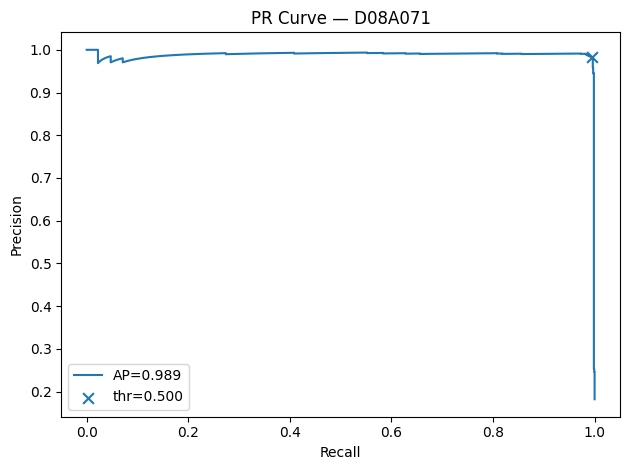

Saved report_artifacts/pr_D08A071.png


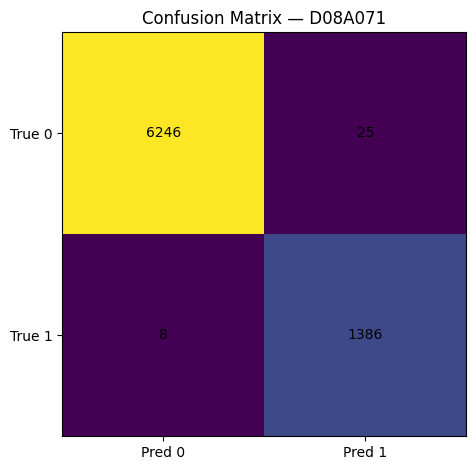

Saved report_artifacts/cm_D08A071.png


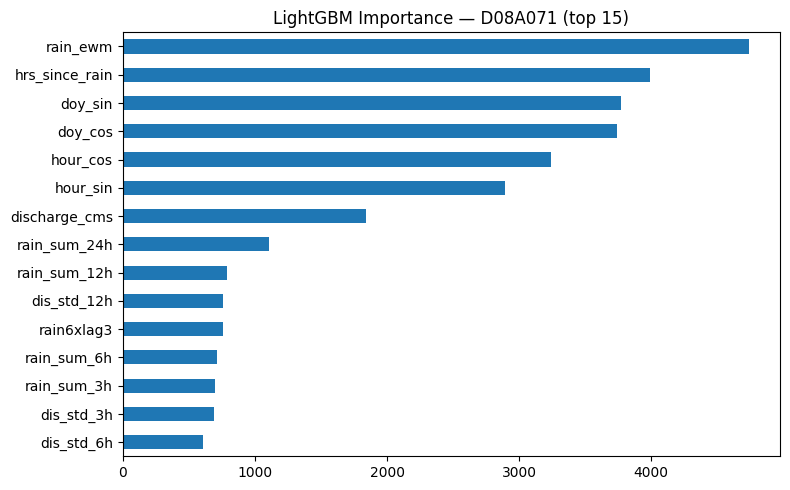

Saved report_artifacts/lgbm_importance_D08A071.png
Notes saved
Saved report_artifacts/ablation_D08A071.csv


,ap,recall,precision,acc,FP,FN
variant,,,,,,
XGB only,0.996234,0.992826,0.985755,0.996086,20,10
+Stack (no LGBM/LSTM),0.990732,0.993544,0.982967,0.995695,24,9
+LGBM,0.991278,0.994261,0.982979,0.995825,24,8
+LSTM,0.988661,0.994261,0.982282,0.995695,25,8


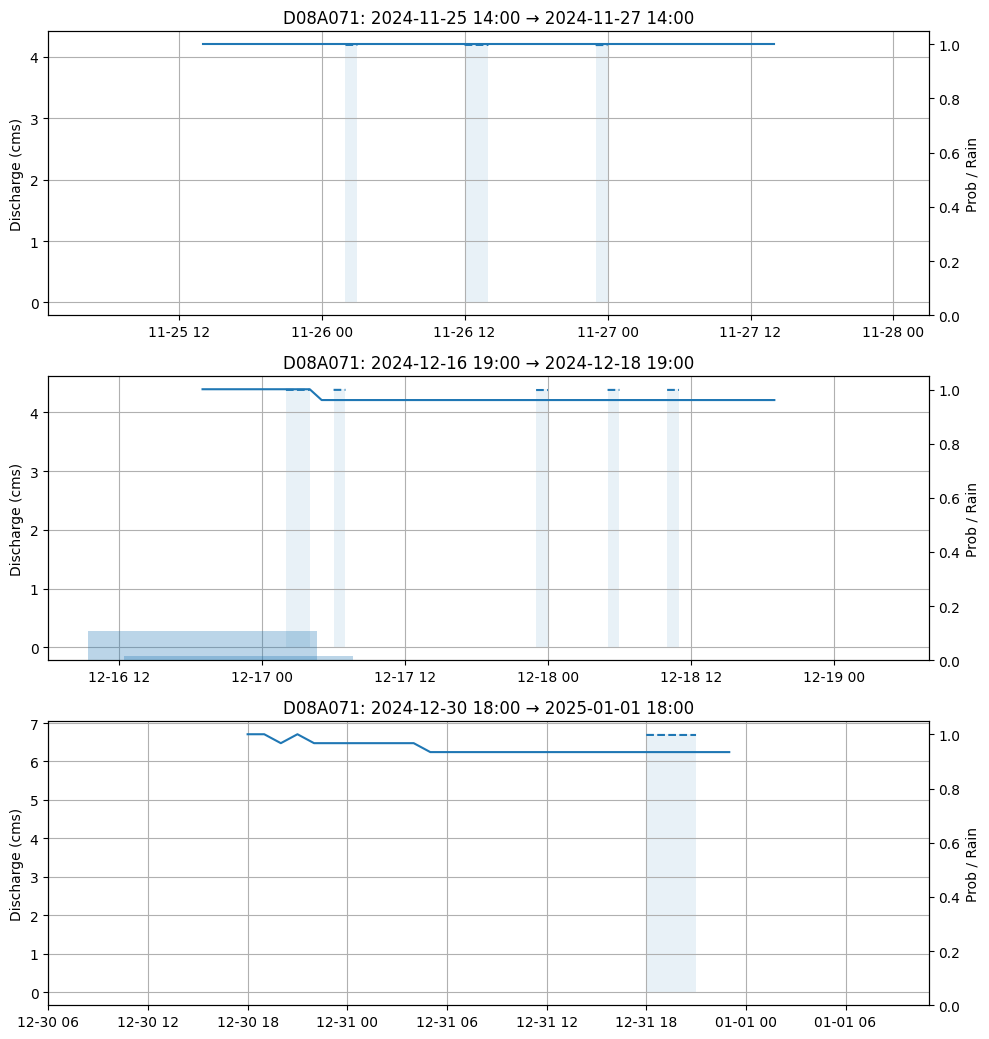

Saved report_artifacts/timeline_D08A071.png

### Station D08A084
Saved report_artifacts/D08A084_topFP.csv and report_artifacts/D08A084_topFN.csv


,proba,y_true,pred,discharge_cms,rain_mm,rain_sum_12h,dis_lag_1h,dis_rate_1h
datetime,,,,,,,,
2024-01-17 12:00:00,0.999900,0.0,1,0.232,0.000000,0.000000,0.232,0.000
2021-12-10 17:00:00,0.999536,0.0,1,0.006,4.582475,43.893627,0.006,0.000
2021-12-05 22:00:00,0.999123,0.0,1,0.093,0.200000,0.286405,0.093,0.000
2021-12-10 16:00:00,0.999107,0.0,1,0.006,25.238343,39.311152,0.006,0.000
2018-02-25 15:00:00,0.999107,0.0,1,0.140,2.686405,6.905736,0.140,0.000
2022-01-07 22:00:00,0.999045,0.0,1,0.093,0.040786,20.634732,0.093,0.000
2021-10-15 21:00:00,0.998996,0.0,1,0.149,0.086405,31.080935,0.000,0.149
2024-12-02 10:00:00,0.998921,0.0,1,0.060,0.000000,3.959533,0.060,0.000
2021-12-07 22:00:00,0.998550,0.0,1,1.332,2.431121,18.516622,1.772,-0.440


,proba,y_true,pred,discharge_cms,rain_mm,rain_sum_12h,dis_lag_1h,dis_rate_1h
datetime,,,,,,,,
2019-05-11 19:00:00,0.012922,1.0,0,0.015,0.000000,0.054381,0.041,-0.026
2018-01-03 04:00:00,0.028972,1.0,0,0.020,0.000000,4.281572,0.020,0.000
2018-01-03 03:00:00,0.029333,1.0,0,0.020,0.000000,4.281572,0.020,0.000
2018-02-14 22:00:00,0.041717,1.0,0,0.000,0.363144,5.074934,0.000,0.000
2018-01-11 20:00:00,0.049607,1.0,0,0.020,0.804833,5.056187,0.020,0.000
2018-01-11 19:00:00,0.051555,1.0,0,0.020,1.404833,4.419331,0.020,0.000
2018-02-14 21:00:00,0.057854,1.0,0,0.000,0.027191,4.711790,0.000,0.000
2024-03-08 06:00:00,0.086609,1.0,0,0.035,1.036856,1.036856,0.035,0.000
2024-03-08 12:00:00,0.145651,1.0,0,0.035,0.000000,3.887307,0.060,-0.025


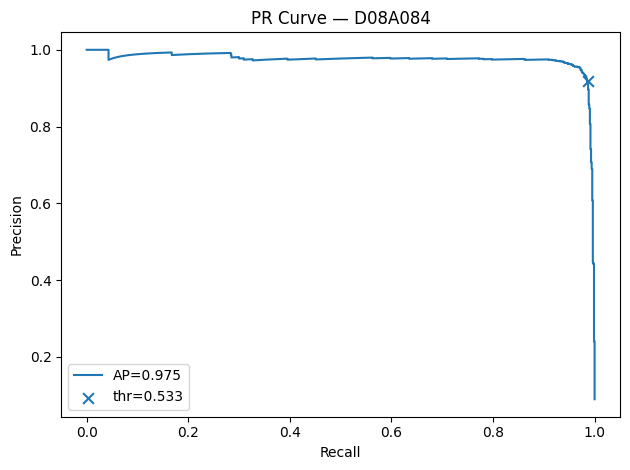

Saved report_artifacts/pr_D08A084.png


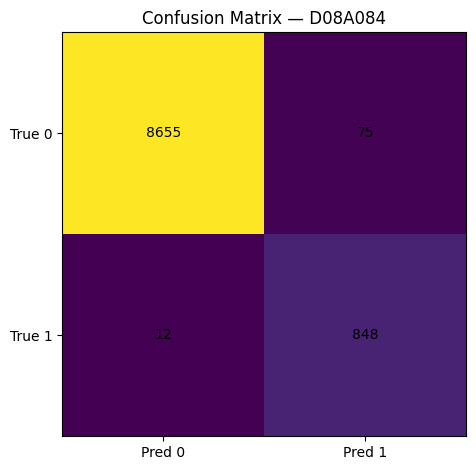

Saved report_artifacts/cm_D08A084.png


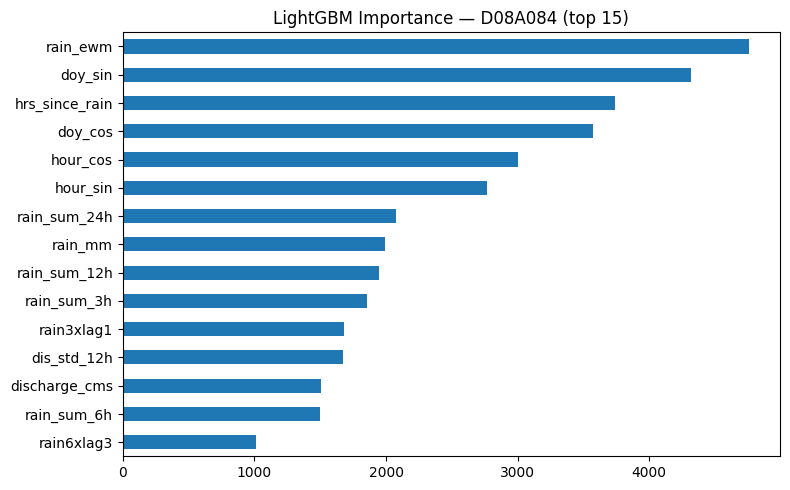

Saved report_artifacts/lgbm_importance_D08A084.png
Notes saved
Saved report_artifacts/ablation_D08A084.csv


,ap,recall,precision,acc,FP,FN
variant,,,,,,
XGB only,0.993628,0.966279,0.965157,0.993848,30,29
+Stack (no LGBM/LSTM),0.975314,0.984884,0.917660,0.990719,76,13
+LGBM,0.973934,0.984884,0.918655,0.990824,75,13
+LSTM,0.975133,0.986047,0.918743,0.990928,75,12


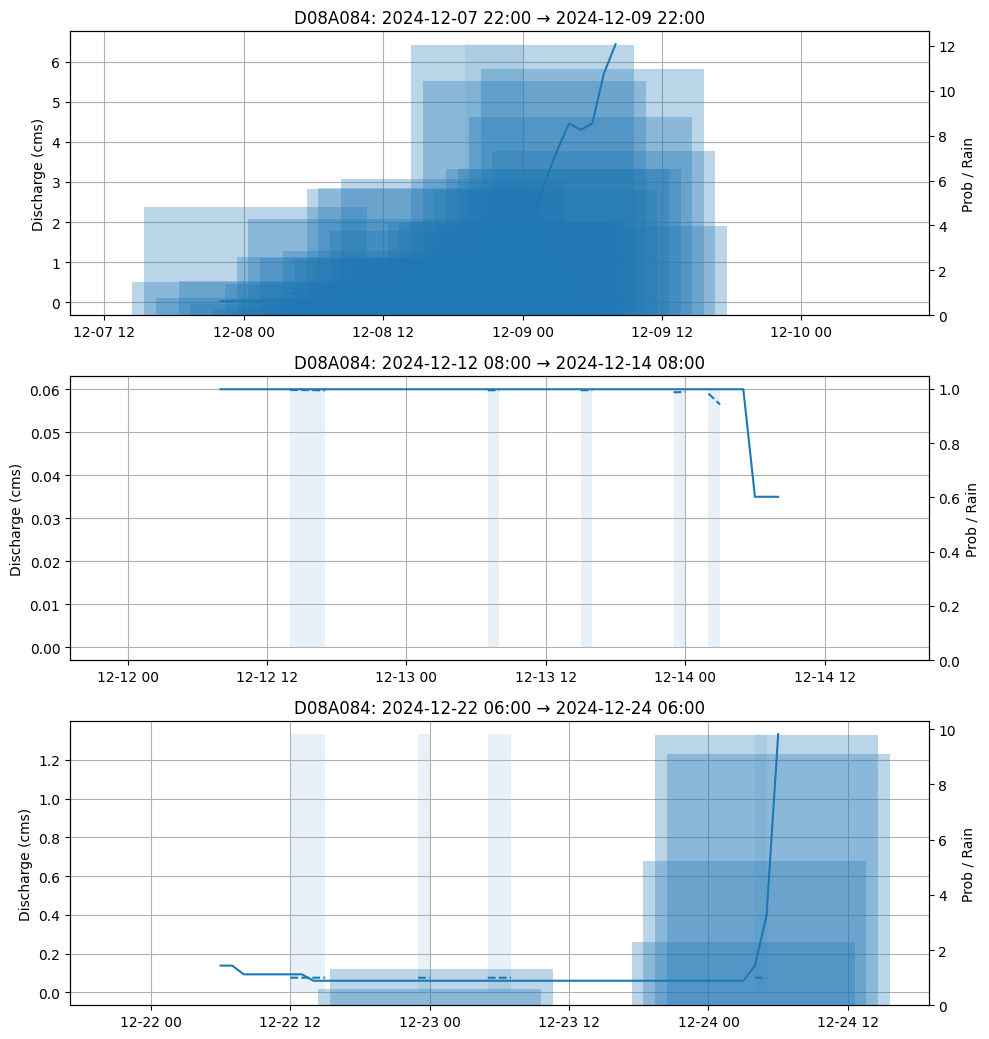

Saved report_artifacts/timeline_D08A084.png

### Station D08A115
Saved report_artifacts/D08A115_topFP.csv and report_artifacts/D08A115_topFN.csv


,proba,y_true,pred,discharge_cms,rain_mm,rain_sum_12h,dis_lag_1h,dis_rate_1h
datetime,,,,,,,,
2018-03-16 11:00:00,0.998056,0.0,1,1.860,0.000000,2.484548,2.000,-0.140
2017-03-10 22:00:00,0.997402,0.0,1,11.160,1.384580,22.239003,10.920,0.240
2018-03-15 10:00:00,0.997320,0.0,1,2.000,0.000000,1.630742,2.000,0.000
2018-02-25 14:00:00,0.997046,0.0,1,1.860,1.076936,1.715387,1.860,0.000
2017-03-07 22:00:00,0.996047,0.0,1,2.060,12.376741,29.323032,2.288,-0.228
2019-03-19 14:00:00,0.995097,0.0,1,5.835,0.000000,0.000000,5.835,0.000
2017-03-12 22:00:00,0.995082,0.0,1,4.168,0.000000,0.200000,4.336,-0.168
2019-03-01 21:00:00,0.994452,0.0,1,6.780,0.000000,0.000000,6.780,0.000
2017-01-18 22:00:00,0.993596,0.0,1,2.288,0.000000,0.000000,2.288,0.000


,proba,y_true,pred,discharge_cms,rain_mm,rain_sum_12h,dis_lag_1h,dis_rate_1h
datetime,,,,,,,,
2019-01-01 22:00:00,0.000428,1.0,0,28.400,1.938419,77.077552,38.860,-10.460
2018-12-15 00:00:00,0.007997,1.0,0,0.759,0.000000,7.753968,0.759,0.000
2024-02-12 21:00:00,0.008838,1.0,0,0.424,0.684613,7.592128,0.424,0.000
2017-03-07 15:00:00,0.010247,1.0,0,0.807,0.000000,0.000000,0.744,0.063
2021-02-05 01:00:00,0.012070,1.0,0,1.204,0.000000,0.000000,1.204,0.000
2018-12-15 17:00:00,0.014232,1.0,0,1.270,0.000000,4.092290,1.270,0.000
2018-11-19 02:00:00,0.024322,1.0,0,0.379,2.930872,33.700454,0.379,0.000
2017-03-07 16:00:00,0.065710,1.0,0,1.122,0.123097,0.123097,0.807,0.315
2016-03-25 21:00:00,0.128864,1.0,0,1.390,0.030774,13.199903,1.390,0.000


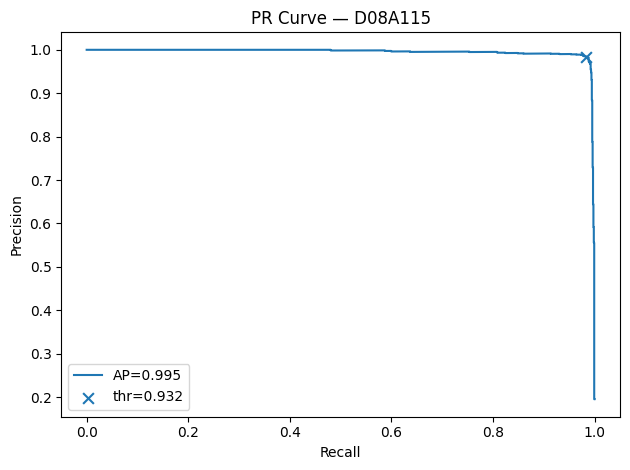

Saved report_artifacts/pr_D08A115.png


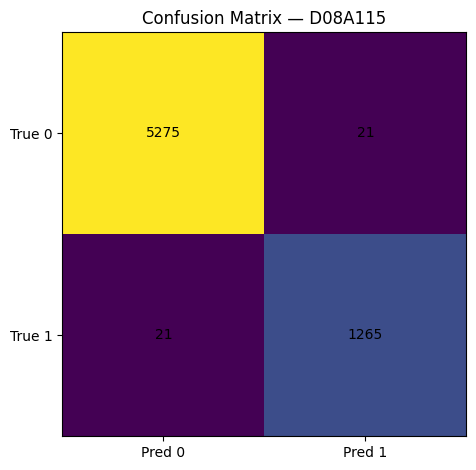

Saved report_artifacts/cm_D08A115.png


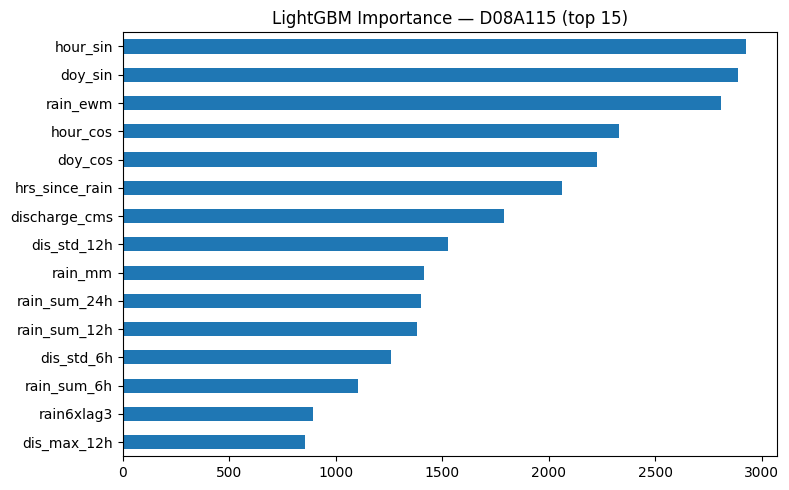

Saved report_artifacts/lgbm_importance_D08A115.png
Notes saved
Saved report_artifacts/ablation_D08A115.csv


,ap,recall,precision,acc,FP,FN
variant,,,,,,
XGB only,0.998283,0.966563,0.992812,0.992100,9,43
+Stack (no LGBM/LSTM),0.994848,0.983670,0.982906,0.993467,22,21
+LGBM,0.995329,0.983670,0.983670,0.993619,21,21
+LSTM,0.994943,0.983670,0.983670,0.993619,21,21


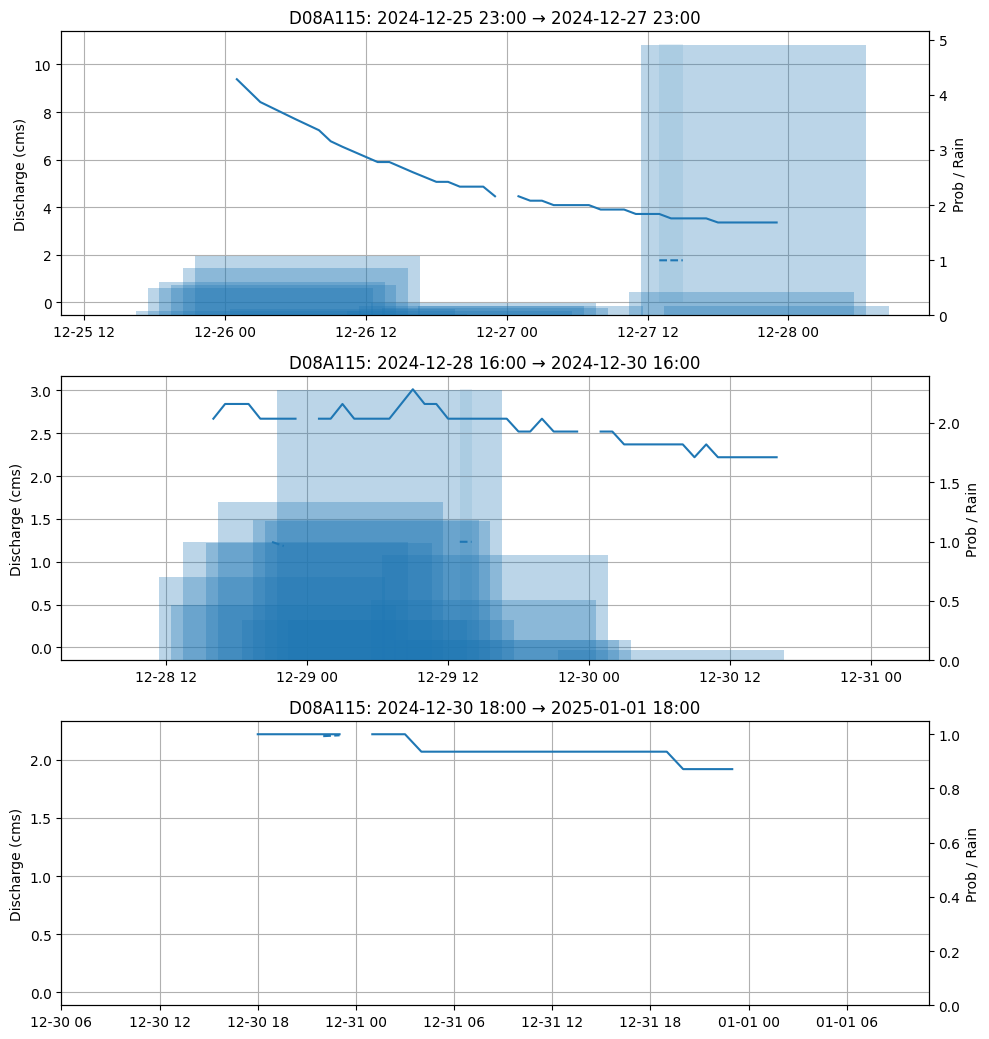

Saved report_artifacts/timeline_D08A115.png

=== Combined Confusion Matrix ===
[[20176   121]
 [   41  3499]]
Overall: Acc=0.993  Prec=0.967  Rec=0.988


In [9]:

combined_cm = np.zeros((2,2), dtype=int)

for code in STATIONS:
    print(f"\n### Station {code}")
    X_tr, X_te, y_tr, y_te, prob, pipe, df_full = train_stack_and_probs(code)
    thr = MY_THR[code]

    # Error tables
    error_analysis_tables(code, X_te, y_te, prob, df_full, thr, topn=20)

    # PR + CM
    plot_pr_with_marker(code, y_te, prob, thr)
    cm = plot_confusion(code, y_te, prob, thr)
    combined_cm += cm

    # LGBM importance + notes
    lgbm_importance_and_notes(code, X_tr, y_tr)

    # Ablation
    ablation_matrix(code, X_tr, X_te, y_tr, y_te, thr)

    # Timeline panels
    base = load_station(code)
    plot_timeline_panels(code, base, X_te, y_te, prob, k=3, hours=48)

print("\n=== Combined Confusion Matrix ===")
print(combined_cm)
_tn,_fp,_fn,_tp = combined_cm.ravel()
_overall_acc = (_tn+_tp)/(_tn+_tp+_fp+_fn)
_overall_prec = (_tp/(_tp+_fp)) if (_tp+_fp)>0 else 0.0
_overall_rec  = (_tp/(_tp+_fn)) if (_tp+_fn)>0 else 0.0
print(f"Overall: Acc={_overall_acc:.3f}  Prec={_overall_prec:.3f}  Rec={_overall_rec:.3f}")
